In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
from going_modular.OneHeadModel import OneHeadModel

import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [2]:
allow_train = True
load_pre_train_model = False
freeze_encoder = False
EPOCHS = 15
BATCH_SIZE = 32
shrink_size = 400

lr = 0.00005
weight_deacay = 0
# T_max = 70
# eta_min = 1e-7
num_augs = 3
p_dropout = 0.5

crop_size = 224

# weights for alpha is inverse frequency

# alpha = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# alpha = torch.tensor([1, 1, 1, 1, 1])
# gamma = 2
# label_smoothing = 0.1

# alpha = [1] * 5
# alpha = [1/1805, 1/370, 1/999, 1/193, 1/295] * 500 

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

In [5]:
# load all dataloaders

train_dataloader, val_dataloader, class_names = custom_data_setup_main_train.create_train_val_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=train_transforms,
    val_transform=test_transforms,
    shrink_size=shrink_size)

test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms, 
    shrink_size=shrink_size) 

exp_train_dataloader, class_names = custom_data_setup_main_train.create_train_dataloader(
    batch_size=BATCH_SIZE,
    train_transform=test_transforms,
    shrink_size=shrink_size)

MESSIDOR_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='MESSIDOR',
    shrink_size=shrink_size)   

IDRID_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='IDRID',
    shrink_size=shrink_size) 

APTOS_15_test_dataloader, class_name = custom_data_setup_main_train.create_exotic_test_dataloader(
    batch_size=BATCH_SIZE,
    test_transform=test_transforms,
    dataset_name='APTOS_15_test',
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2489083].


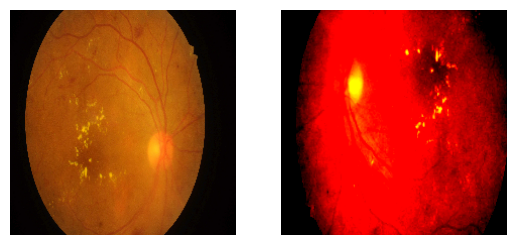

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(model=model, 
        input_size=(32, 3, 240, 240), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                   [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                        [32, 3, 240, 240]    [32, 1024, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 3, 240, 240]    [32, 64, 120, 120]   9,408                True
│    └─BatchNorm2d (norm0)                    [32, 64, 120, 120]   [32, 64, 120, 120]   128                  True
│    └─ReLU (relu0)                           [32, 64, 120, 120]   [32, 64, 120, 120]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 120, 120]   [32, 64, 60, 60]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 60, 60]     [32, 256, 60, 60]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 60, 60]     [32, 32, 60, 60]    

Custom Focal Loss function

In [9]:
# class FocalLoss_custom(torch.nn.Module):
#     def __init__(self, alpha, gamma, headType=None):
#         super(FocalLoss_custom, self).__init__()
#         self.alpha = alpha.to(device)
#         self.gamma = gamma
#         self.headType = headType
#     def forward(self, inputs, targets):
        
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=0.1)
#         # apply class weights
#         # alpha is for the weight class, weights is the correct weight for each class and looks like this: tensor([a, b, c, d, a, ...])
#         weights = self.alpha.gather(0, targets)

#         pt = torch.exp(-ce_loss)
#         loss = (weights * ((1 - pt) ** self.gamma) * ce_loss)
#         # loss = (self.alpha * ((1 - pt) ** self.gamma) * ce_loss)
#         return loss.mean()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, label_smoothing=0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha.to(device)
        self.gamma = gamma
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss

In [11]:
# Define loss and optimizer

# from going_modular.focal_loss import FocalLoss

# weights are selected based on the APTOS 2019 distribution according to the paper
# weight = torch.tensor([3260/1750, 3260/270, 3260/840, 3260/140, 3260/260]) * 0.1
# weight = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 

# weights.to(device)

loss_fn_classification = nn.BCEWithLogitsLoss().to(device)

# loss_fn_classification = nn.CrossEntropyLoss().to(device)
# loss_fn_classification = nn.CrossEntropyLoss(weight=weight).to(device)
# loss_fn_classification = FocalLoss_custom(headType='classification', alpha=alpha, gamma=gamma).to(device)
# loss_fn_classification = FocalLoss(alpha=alpha, gamma=gamma, label_smoothing=label_smoothing).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_deacay)

# scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

In [12]:
# model = torch.compile(model)

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results

    train_results, val_results = engine.train(model=model,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn_classification=loss_fn_classification,
                epochs=EPOCHS,
                device=device)
    
    helper_functions.plot_t_SNE(model=model,
                            dataloader=val_dataloader,
                            NUM_ITER=2000)
    
    utils.save_model(model=model, target_dir='models', model_name=f'main_train_model.pth')


    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")
else:
    model.load_state_dict(torch.load('models/main_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/15 [00:00<?, ?it/s]

ValueError: Target size (torch.Size([32, 4])) must be the same as input size (torch.Size([32, 5]))

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=test_dataloader,
            device=device)

In [ ]:
test_results = engine.test_step(model=model,
            dataloader=exp_train_dataloader,
            device=device)

In [ ]:
MESSIDOR_test_results = engine.test_step(model=model,
            dataloader=MESSIDOR_dataloader,
            device=device)

In [ ]:
IDRID_test_results = engine.test_step(model=model,
            dataloader=IDRID_dataloader,
            device=device)

In [ ]:
APTOS_15_test_results = engine.test_step(model=model,
            dataloader=APTOS_15_test_dataloader,
            device=device)

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=test_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)